In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [10]:
generation_categories_test = np.load("ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/generation_categories_test.npy")
hidden_states_test = np.load("ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/hidden_states_test.npy")

In [49]:

train_idxs = np.random.choice(len(generation_categories_test), int(0.8*len(generation_categories_test)), replace=False)
test_idxs = np.array([i for i in range(len(generation_categories_test)) if i not in train_idxs])




In [90]:
layer = 6

mean = np.mean(hidden_states_test[layer], axis=0)

X = hidden_states_test[layer]-mean

y = generation_categories_test[:, 3]

X_train = X[train_idxs]
y_train = y[train_idxs]

X_test = X[test_idxs]
y_test = y[test_idxs]

In [91]:

# Linear Regression
lr = SGDClassifier(alpha=0.0001)
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.9059478435305918

In [92]:
lr.score(X_test, y_test)

0.8992577733199599

In [93]:
generated_answer_log_probs_mean_test = np.load("ckpts/sft_ctrex_llama7B_2_commit_lr1e-5_2/checkpoint_30000/hf_model/generated_answer_log_probs_mean_test.npy")

In [96]:
np.save("ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/mean_6.npy", mean)
np.save("ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/coef_6.npy", lr.coef_)
np.save("ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/intercept_6.npy", lr.intercept_)

In [94]:
lr.intercept_

array([0.26107783])

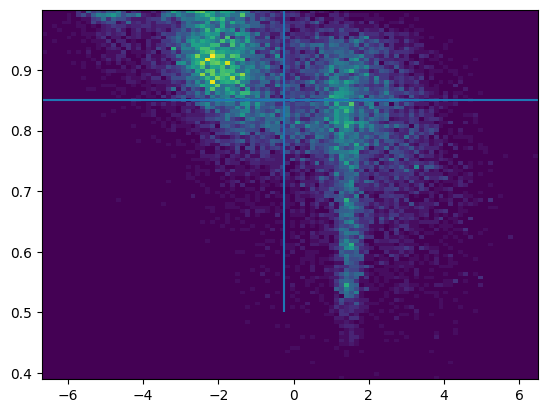

In [95]:
random_idxs = np.random.choice(len(generated_answer_log_probs_mean_test), 20000, replace=False)

plt.scatter(np.dot(X, lr.coef_.T).squeeze()[random_idxs],np.e**generated_answer_log_probs_mean_test[random_idxs], alpha=0.003)
# plt.hist2d(np.dot(X, lr.coef_.T).squeeze()[random_idxs],np.e**generated_answer_log_probs_mean_test[random_idxs], bins=100)
plt.hlines(0.85, -7.5, 7.5)
plt.vlines(-lr.intercept_, 0.5, 1)

plt.savefig("fig.png")

In [2]:
generation_categories_ood = np.load("ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/generation_categories.npy")
hidden_states_ood = np.load("ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/hidden_states_ood.npy")

In [3]:
generated_answer_log_probs_mean_ood = np.load("ckpts/sft_ctrex_llama7B_2_commit_lr1e-5_2/checkpoint_30000/hf_model/generated_answer_log_probs_mean_ood.npy")
sft_generation_categories_ood = np.load("ckpts/sft_ctrex_llama7B_2_commit_lr1e-5_2/checkpoint_30000/hf_model/generation_categories.npy")


In [4]:
layer = 6
mean = np.load("ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/mean_6.npy")
coef = np.load("ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/coef_6.npy")
intercept = np.load("ckpts/ppo_ctrex_llama7B_commit35_idk10/best_checkpoint/hf_model/intercept_6.npy")


In [5]:

X = hidden_states_ood[layer]-mean

y = generation_categories_ood[:, 3]

In [6]:
(((np.dot(X, coef.T).squeeze()+intercept)>0) == y).mean()

0.775616707427449

In [7]:
sft_correct = np.where(sft_generation_categories_ood[:, 1]==1)[0]
sft_incorrect = np.where(sft_generation_categories_ood[:, 1]==0)[0]

ppo_commit = np.where(generation_categories_ood[:, 3]==0)[0]
ppo_idk = np.where(generation_categories_ood[:, 3]==1)[0]

In [8]:
from functools import reduce

In [1]:
reduce(np.intersect1d,(random_idxs, sft_correct, ppo_commit))

NameError: name 'reduce' is not defined

Text(0.5, 1.0, 'OOD set')

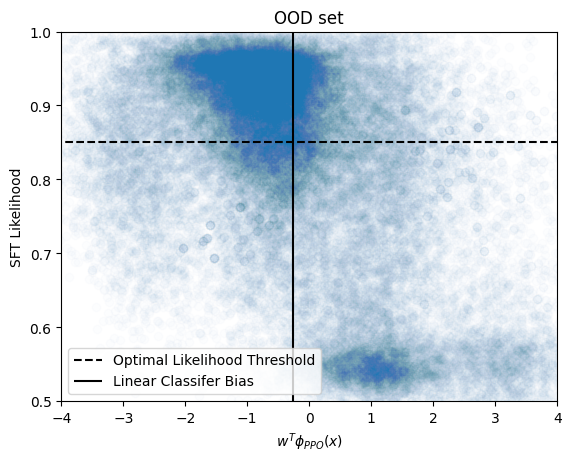

: 

In [12]:
random_idxs = np.random.choice(len(generated_answer_log_probs_mean_ood), 50000, replace=False)

plt.scatter(np.dot(X, coef.T).squeeze()[random_idxs],np.e**generated_answer_log_probs_mean_ood[random_idxs], alpha=0.01)
plt.hlines(0.85, -7.5, 7.5,linestyles="--", color="black", label="Optimal Likelihood Threshold")
plt.vlines(-intercept, 0.5, 1,color="black", label="Linear Classifer Bias")
plt.ylim(0.5, 1)
plt.xlim(-4, 4)
plt.ylabel('SFT Likelihood')
plt.xlabel('$w^T \phi_{PPO}(x)$')
plt.legend()

plt.title("OOD set")


# plt.savefig("fig.png")

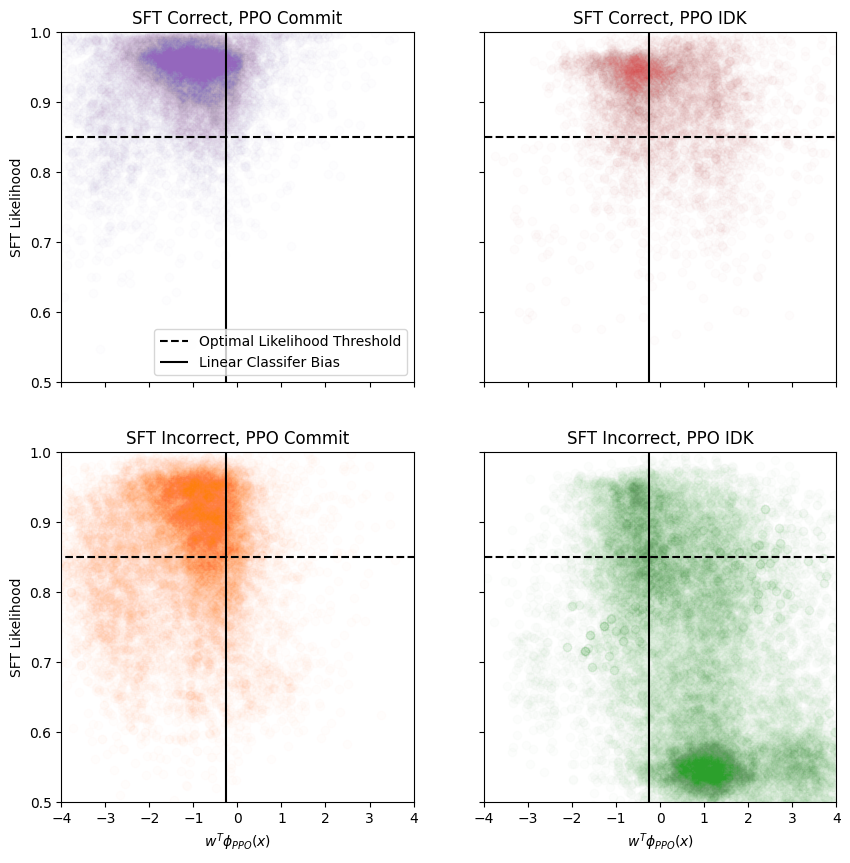

In [12]:
# make 2 by 2 subplots

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
axs[1, 0].scatter(np.dot(X, coef.T).squeeze()[reduce(np.intersect1d,(random_idxs, sft_incorrect, ppo_commit))],np.e**generated_answer_log_probs_mean_ood[reduce(np.intersect1d,(random_idxs, sft_incorrect, ppo_commit))], alpha=0.01, color="C1")
axs[1, 0].set_title('SFT Incorrect, PPO Commit')
axs[1, 0].set_ylabel('SFT Likelihood')
axs[1, 0].set_xlabel('$w^T \phi_{PPO}(x)$')



axs[1, 1].scatter(np.dot(X, coef.T).squeeze()[reduce(np.intersect1d,(random_idxs, sft_incorrect, ppo_idk))],np.e**generated_answer_log_probs_mean_ood[reduce(np.intersect1d,(random_idxs, sft_incorrect, ppo_idk))], alpha=0.01, color="C2")
axs[1, 1].set_title('SFT Incorrect, PPO IDK')
axs[1, 1].set_xlabel('$w^T \phi_{PPO}(x)$')

axs[0, 1].scatter(np.dot(X, coef.T).squeeze()[reduce(np.intersect1d,(random_idxs, sft_correct, ppo_idk))],np.e**generated_answer_log_probs_mean_ood[reduce(np.intersect1d,(random_idxs, sft_correct, ppo_idk))], alpha=0.01, color="C3")
axs[0, 1].set_title('SFT Correct, PPO IDK')
axs[0, 0].scatter(np.dot(X, coef.T).squeeze()[reduce(np.intersect1d,(random_idxs, sft_correct, ppo_commit))],np.e**generated_answer_log_probs_mean_ood[reduce(np.intersect1d,(random_idxs, sft_correct, ppo_commit))], alpha=0.01, color="C4")
axs[0, 0].set_title('SFT Correct, PPO Commit')
axs[0, 0].set_ylabel('SFT Likelihood')


axs[0, 0].hlines(0.85, -7.5, 7.5,linestyles="--", color="black", label="Optimal Likelihood Threshold")
axs[0, 0].vlines(-intercept, 0.5, 1,color="black", label="Linear Classifer Bias")
axs[0, 0].legend()
axs[0, 0].set_ylim(0.5, 1)
axs[0, 0].set_xlim(-4, 4)

axs[0, 1].hlines(0.85, -7.5, 7.5,linestyles="--", color="black", label="Optimal Likelihood Threshold")
axs[0, 1].vlines(-intercept, 0.5, 1,color="black", label="Linear Classifer Bias")
axs[1, 0].hlines(0.85, -7.5, 7.5,linestyles="--", color="black", label="Optimal Likelihood Threshold")
axs[1, 0].vlines(-intercept, 0.5, 1,color="black", label="Linear Classifer Bias")
axs[1, 1].hlines(0.85, -7.5, 7.5,linestyles="--", color="black", label="Optimal Likelihood Threshold")
axs[1, 1].vlines(-intercept, 0.5, 1,color="black", label="Linear Classifer Bias")

# plt.savefig("fig.png")